<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/ROC_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From: https://github.com/thongonary/Thoughts/blob/master/ROC_uncertainty.ipynb
## Uncertainty band for ROC curve with Wilson interval

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

### Generate a random ROC curve

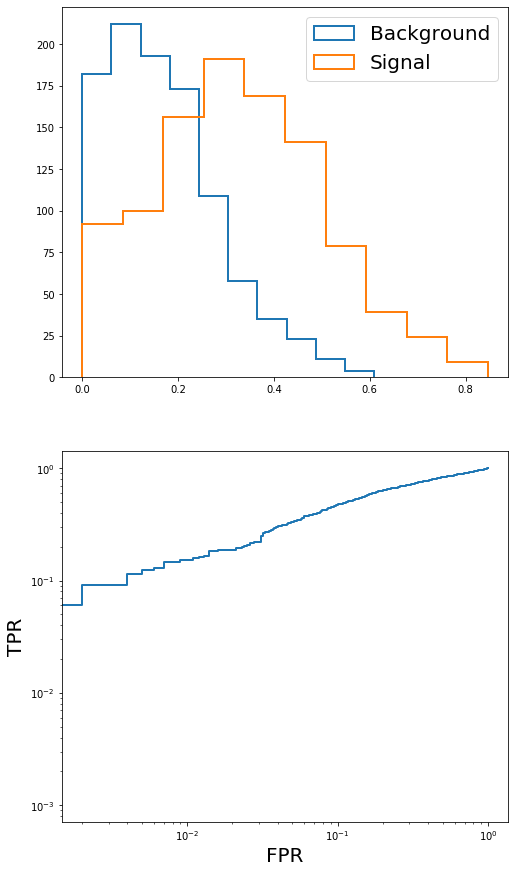

In [ ]:
size = int(1e3)
label = np.concatenate((np.ones(size), np.zeros(size)))

def gen_clipped_gauss(mean, std, size):
    pred = np.random.normal(mean, std, int(size*1e3))
    pred = pred[(pred < 1.0) & (pred > 0.0)]
    pred = np.random.choice(pred, size)
    return pred

pred_sig = gen_clipped_gauss(0.3, 0.2, size)
pred_bkg = gen_clipped_gauss(0.1, 0.16, size)
pred = np.concatenate((pred_sig, pred_bkg))

fpr, tpr, threshold = roc_curve(label, pred)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(8,15))
ax0.hist(pred_bkg, linewidth=2, label='Background', histtype='step')
ax0.hist(pred_sig, linewidth=2, label='Signal', histtype='step')
ax0.legend(loc='best', fontsize=20)

ax1.plot(fpr, tpr, linewidth=2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('FPR', fontsize=20)
ax1.set_ylabel('TPR', fontsize=20)
fig.show()

### Add Wilson interval

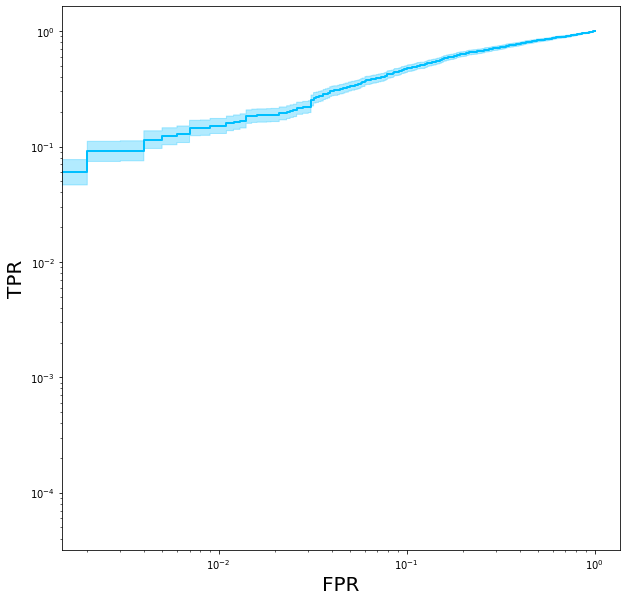

In [ ]:
# https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval_with_continuity_correction
def upper_wilson(p, n, z=1.96):
    # z is the z-score of (1 - alpha/2) quantile. For 95% CI, alpha=0.05, z=1.96.
    # We can also use z = 1 (ie, 1 sigma). Just make sure to elaborate 
    # in the caption which value did we choose.
    A = 2 * n * p
    B = np.power(z, 2)
    C = z * np.sqrt(np.power(z, 2) - 1./n + 4 * n * p * (1 - p) - (4 * p - 2)) + 1
    D = 2 * (n + np.power(z, 2))
    ratio = (A + B + C)/D
    ratio = np.where(ratio < 1, ratio, 1)
    return ratio
def lower_wilson(p, n, z=1.96):
    A = 2 * n * p
    B = np.power(z, 2)
    C = z * np.sqrt(np.power(z, 2) - 1./n + 4 * n * p * (1 - p) + (4 * p - 2)) + 1
    D = 2 * (n + np.power(z, 2))
    ratio = (A + B - C)/D
    ratio = np.where(ratio > 0, ratio, 0)
    return ratio

upper_tpr = upper_wilson(tpr, size)
lower_tpr = lower_wilson(tpr, size)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(fpr, tpr, linewidth=2, color='deepskyblue')
ax.fill_between(fpr, lower_tpr, upper_tpr, color='deepskyblue', alpha=0.3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('FPR', fontsize=20)
ax.set_ylabel('TPR', fontsize=20)
fig.show()

### Optional: Agresti-Coull interval

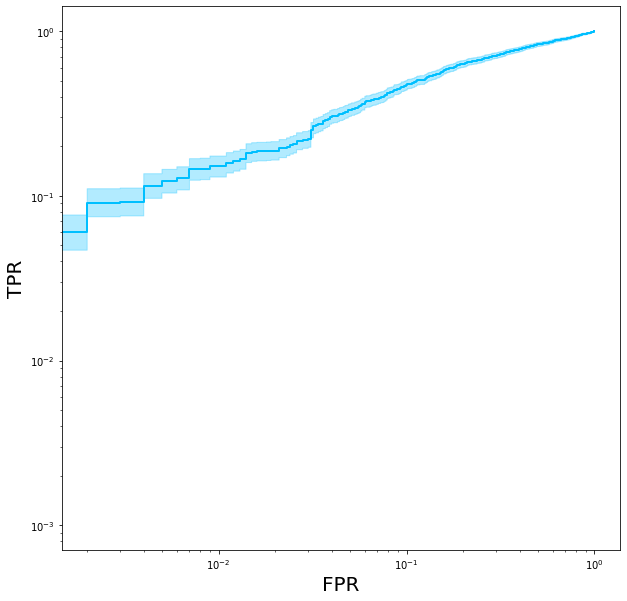

In [ ]:
# https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Agresti%E2%80%93Coull_interval
def ac_interval(p, n, z=1.96):
    nbar = n + np.power(z, 2)
    X = p * n
    pbar = 1./nbar * (X + np.power(z, 2)/2.)
    upper = pbar + z * np.sqrt(pbar/nbar * (1 - pbar))
    lower = pbar - z * np.sqrt(pbar/nbar * (1 - pbar))
    return upper, lower

upper_tpr, lower_tpr = ac_interval(tpr, size)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(fpr, tpr, linewidth=2, color='deepskyblue')
ax.fill_between(fpr, lower_tpr, upper_tpr, color='deepskyblue', alpha=0.3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('FPR', fontsize=20)
ax.set_ylabel('TPR', fontsize=20)
fig.show()

Both formula are correct, so just go with whatever you like